In [1]:
#=======================================================
# 1. ANÁLISE DE METADADOS DOS DATASETS
#=======================================================

import pandas as pd
import os

# Configurações de diretórios
diretorio_dados = os.path.join(os.getcwd(), 'dados')
diretorio_saida = os.path.join(os.getcwd(), 'pre_analise')
arquivo_saida = os.path.join(diretorio_saida, 'analise_metadados_datasets.xlsx')

arquivos = {
    'emprestimos': 'emprestimos.csv',
    'serasa': 'serasa.csv',
    'anteriores': 'emprestimos_anteriores.csv'
}

# Criar pasta pre_analise se não existir
if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)

def analisar_dataframe(nome, path):
    full_path = os.path.join(diretorio_dados, path)
    
    if not os.path.exists(full_path):
        print(f"Aviso: Arquivo {path} não encontrado.")
        return None

    # Carregando apenas as primeiras linhas para análise de metadados
    df = pd.read_csv(full_path, sep=';', encoding='utf-8', nrows=5)
    
    info_colunas = []
    
    for col in df.columns:
        dtype = df[col].dtype
        
        # Lógica de inferência estatística
        if dtype == 'object':
            tipo_estatistico = "Nominal/Categorizado"
            num_tipo = "Discreto"
        elif 'AMT' in col or 'SOURCE' in col:
            tipo_estatistico = "Racional"
            num_tipo = "Contínuo"
        elif 'DAYS' in col:
            tipo_estatistico = "Intervalar"
            num_tipo = "Discreto"
        elif 'CNT' in col or 'count' in col.lower() or 'Qtde' in col:
            tipo_estatistico = "Racional"
            num_tipo = "Discreto"
        else:
            tipo_estatistico = "Indeterminado (Requer inspeção)"
            num_tipo = "Discreto"
            
        origem = "Derivado" if (col.startswith('count') or col in ['Divida_atrasada', 'Qtde_emprestimos']) else "Univalorado/Original"

        info_colunas.append({
            "Atributo": col,
            "Dtype": str(dtype),
            "Escala": tipo_estatistico,
            "Natureza": origem,
            "Tipo Numérico": num_tipo
        })

    return pd.DataFrame(info_colunas)

# --- EXECUÇÃO E SALVAMENTO EM EXCEL ---

# O ExcelWriter permite criar múltiplas abas
with pd.ExcelWriter(arquivo_saida, engine='openpyxl') as writer:
    for nome, arquivo in arquivos.items():
        resultado = analisar_dataframe(nome, arquivo)
        
        if resultado is not None:
            # Salva cada análise em uma aba com o nome do dataset
            resultado.to_excel(writer, sheet_name=nome, index=False)
            print(f"Análise de '{nome}' processada e adicionada ao Excel.")

print(f"\n[SUCESSO] Tabela consolidada criada em: {arquivo_saida}")

Análise de 'emprestimos' processada e adicionada ao Excel.
Análise de 'serasa' processada e adicionada ao Excel.
Análise de 'anteriores' processada e adicionada ao Excel.

[SUCESSO] Tabela consolidada criada em: c:\Users\kensl\OneDrive\37_Sistema_de_Informacao\Curso\4o_Semestre\1_Disciplinas\Ciencia_de_Dados\Trabalho\Base_dados\Pre_Processamento\pre_analise\analise_metadados_datasets.xlsx


In [2]:
#=======================================
# Categorização da ausência de registros
#=======================================

import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr, spearmanr

# Lista de ruídos (mantenha a sua, ela está excelente)
na_list = ["", " ", "  ", "\t", "?", "-", "--", "---", "NA", "N/A", "na", "n/a", "NULL", "null", "None", "nan", "NaN", "NAN"]

def categorizar_ausencia_robusta(df, col_alvo):
    """
    Categorização avançada de mecanismos de ausência.
    """
    total_null = df[col_alvo].isnull().sum()
    if total_null == 0:
        return "Sem Ausência"
    
    # Flag binária para ausência
    is_missing = df[col_alvo].isnull().astype(int)
    
    # 1. Teste para MAR (Missing at Random)
    # Verificamos se a ausência correlaciona com QUALQUER outra variável numérica disponível
    max_corr = 0
    cols_numericas = df.select_dtypes(include=[np.number]).columns
    
    for col in cols_numericas:
        if col == col_alvo: continue
        
        # Usamos fillna temporário para calcular correlação sem descartar linhas
        temp_col = df[col].fillna(df[col].median())
        
        # Spearman é mais robusto para relações não-lineares
        corr, _ = spearmanr(is_missing, temp_col)
        max_corr = max(max_corr, abs(corr))
        
        if max_corr > 0.15: # Threshold levemente maior para evitar falsos positivos
            break 

    # 2. Teste para NMAR (Missing Not at Random)
    # Se a coluna é "AMT" (valores) e os dados presentes são muito assimétricos
    # ou se a média dos valores presentes é muito diferente da mediana (outliers)
    is_nmar = False
    if df[col_alvo].dtype in [np.float64, np.int64]:
        skewness = df[col_alvo].skew()
        if abs(skewness) > 2.5: # Forte indício de que valores extremos tendem a faltar
            is_nmar = True

    # Decisão Hierárquica
    if max_corr > 0.15:
        return "MAR (Dependente de outras variáveis)"
    elif is_nmar:
        return "NMAR (Provável: Depende do próprio valor)"
    else:
        return "MCAR (Aleatória)"

def processar_datasets_com_ausencia(diretorio='dados'):
    arquivos = ['emprestimos.csv', 'serasa.csv', 'emprestimos_anteriores.csv']
    
    for arq in arquivos:
        caminho = os.path.join(diretorio, arq)
        if not os.path.exists(caminho): continue
        
        df = pd.read_csv(caminho, sep=';', na_values=na_list)
        print(f"\n--- Diagnóstico Robusto: {arq} ---")
        relatorio = []

        for col in df.columns:
            total_null = df[col].isnull().sum()
            if total_null > 0:
                perc = (total_null / len(df)) * 100
                
                # Categoria usando a nova lógica
                categoria = categorizar_ausencia_robusta(df, col)
                
                # Estratégia Recomendada
                if perc < 5 and categoria == "MCAR":
                    acao = "REMOVER (Baixo impacto)"
                elif categoria == "MAR":
                    acao = "IMPUTAR (Média/Mediana ou Regressão)"
                elif categoria == "NMAR":
                    acao = "MANTER / FLAG (Criar coluna 'is_null')"
                else:
                    acao = "ANALISAR (Impacto alto)"
                
                relatorio.append({
                    "Atributo": col,
                    "Qtd": total_null,
                    "Perc (%)": round(perc, 2),
                    "Categoria": categoria,
                    "Estratégia": acao
                })
        
        if relatorio:
            print(pd.DataFrame(relatorio).to_string(index=False))
        else:
            print("Nenhum dado ausente detectado.")

# Chamar a função
processar_datasets_com_ausencia()


--- Diagnóstico Robusto: emprestimos.csv ---
       Atributo    Qtd  Perc (%)                            Categoria              Estratégia
OCCUPATION_TYPE  96391     31.35 MAR (Dependente de outras variáveis) ANALISAR (Impacto alto)
   EXT_SOURCE_1 173378     56.38 MAR (Dependente de outras variáveis) ANALISAR (Impacto alto)
   EXT_SOURCE_2    660      0.21                     MCAR (Aleatória) ANALISAR (Impacto alto)
   EXT_SOURCE_3  60965     19.83                     MCAR (Aleatória) ANALISAR (Impacto alto)

--- Diagnóstico Robusto: serasa.csv ---
              Atributo     Qtd  Perc (%)                                 Categoria              Estratégia
   DAYS_CREDIT_ENDDATE  105553      6.15 NMAR (Provável: Depende do próprio valor) ANALISAR (Impacto alto)
AMT_CREDIT_MAX_OVERDUE 1124488     65.51 NMAR (Provável: Depende do próprio valor) ANALISAR (Impacto alto)
        AMT_CREDIT_SUM      13      0.00 NMAR (Provável: Depende do próprio valor) ANALISAR (Impacto alto)
   AMT_CREDIT_S

In [ ]:
#=======================================================
# 2. TRATAMENTO DE QUALIDADE DOS DATASETS 
#=======================================================

import pandas as pd
import numpy as np
import os
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Configurações
diretorio = 'dados'
diretorio_saida = 'pre_analise' 
arquivos = ['emprestimos.csv', 'serasa.csv', 'emprestimos_anteriores.csv']
na_list = ["", " ", "  ", "\t", "?", "-", "--", "---", "NA", "N/A", "na", "n/a", "NULL", "null", "None", "nan", "NaN", "NAN"]

if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)

def processamento_completo_v3(nome_arq):
    caminho = os.path.join(diretorio, nome_arq)
    if not os.path.exists(caminho): return None

    # 1. CARREGAMENTO E NORMALIZAÇÃO SEMÂNTICA INICIAL
    df = pd.read_csv(caminho, sep=';', na_values=na_list, keep_default_na=True)
    
    # Normalização de Strings
    cols_texto = df.select_dtypes(include=['object']).columns
    for col in cols_texto:
        df[col] = df[col].astype(str).str.strip().str.upper()

    # Dicionário de Metadados para o Relatório
    relatorio = {
        "dataset": nome_arq,
        "linhas_iniciais": len(df),
        "atributos_iniciais": len(df.columns),
        "duplicados_removidos": 0,
        "mcar_removidos": 0,
        "mar_mice_cols": 0,
        "nmar_flags": [],
        "outliers_identificados": {},
        "cols_normalizadas": [],
        "cols_encodadas": [],
        "linhas_finais": 0,
        "consolidado": False
    }

    # 2. REGISTROS DUPLICADOS
    duplicados = df.duplicated().sum()
    df = df.drop_duplicates()
    relatorio["duplicados_removidos"] = duplicados

    # 3. IDENTIFICAÇÃO DE OUTLIERS (IQR)
    cols_num = df.select_dtypes(include=[np.number]).columns
    for col in cols_num:
        if 'ID' in col or 'TARGET' in col: continue
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        iqr = q3 - q1
        l_inf, l_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        
        fora_inf = (df[col] < l_inf).sum()
        fora_sup = (df[col] > l_sup).sum()
        total_out = fora_inf + fora_sup
        
        if total_out > 0:
            relatorio["outliers_identificados"][col] = {
                'total': int(total_out), 'inf': int(fora_inf), 'sup': int(fora_sup)
            }

    # 4. TRATAMENTO DE AUSENTES
    # NMAR - Flag + Zero
    cols_nmar = [c for c in df.columns if 'AMT' in c or 'DAYS' in c]
    for col in cols_nmar:
        if df[col].isnull().any():
            df[f'{col}_IS_NULL'] = df[col].isnull().astype(int)
            df[col] = df[col].fillna(0)
            relatorio["nmar_flags"].append(f'{col}_IS_NULL')

    # MCAR - Remoção
    for col in df.columns:
        nulos = df[col].isnull().sum()
        if 0 < nulos < (len(df) * 0.05):
            df = df.dropna(subset=[col])
            relatorio["mcar_removidos"] += nulos

    # MAR - MICE RF
    cols_mar = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()].tolist()
    if cols_mar:
        imputer = IterativeImputer(
            estimator=RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1),
            max_iter=5, random_state=42
        )
        df[cols_mar] = imputer.fit_transform(df[cols_mar])
        relatorio["mar_mice_cols"] = len(cols_mar)

    # 5. ENCODING E NORMALIZAÇÃO
    le = LabelEncoder()
    cols_cat = df.select_dtypes(include=['object']).columns
    for col in cols_cat:
        df[col] = le.fit_transform(df[col].fillna('NAO_INFORMADO').astype(str))
        relatorio["cols_encodadas"].append(col)

    cols_scale = [c for c in df.columns if 'AMT' in c or 'EXT_SOURCE' in c]
    if cols_scale:
        scaler = StandardScaler()
        df[cols_scale] = scaler.fit_transform(df[cols_scale].fillna(0))
        relatorio["cols_normalizadas"] = cols_scale

    # 6. CONSOLIDAÇÃO
    if 'SK_ID_CURR' in df.columns and nome_arq != 'emprestimos.csv':
        relatorio["consolidado"] = True
        df = df.groupby('SK_ID_CURR').mean().reset_index()

    relatorio["linhas_finais"] = len(df)
    df.to_csv(os.path.join(diretorio_saida, f"final_{nome_arq}"), sep=';', index=False)
    return relatorio

# --- EXECUÇÃO ---
resultados = [processamento_completo_v3(arq) for arq in arquivos]

# --- IMPRESSÃO DO NOVO RELATÓRIO MESCLADO ---
print(f"\n{'='*95}")
print(f"{'RELATÓRIO CONSOLIDADO: ENGENHARIA DE DADOS E QUALIDADE':^95}")
print(f"{'='*95}")

for r in resultados:
    if r is None: continue
    print(f"\nDATASET: {r['dataset']}")
    print(f"  [VOLUMETRIA E LIMPEZA]")
    print(f"    - Linhas: {r['linhas_iniciais']} (Início) -> {r['linhas_finais']} (Final)")
    print(f"    - Registros Duplicados Removidos: {r['duplicados_removidos']}")
    print(f"    - Consolidado por SK_ID_CURR: {'SIM' if r['consolidado'] else 'NÃO'}")

    print(f"\n  [SANEAMENTO DE NULOS]")
    print(f"    - MCAR (Linhas descartadas): {r['mcar_removidos']}")
    print(f"    - MAR (Colunas via MICE-RF): {r['mar_mice_cols']}")
    print(f"    - NMAR (Flags criadas): {len(r['nmar_flags'])}")

    print(f"\n  [QUALIFICAÇÃO DE OUTLIERS (IQR)]")
    if r['outliers_identificados']:
        # Ordenar pelos top 3 maiores outliers
        top_outliers = dict(sorted(r['outliers_identificados'].items(), key=lambda x: x[1]['total'], reverse=True)[:3])
        for col, d in top_outliers.items():
            print(f"    * {col:25} | Total: {d['total']:6} | (Inf: {d['inf']:6} | Sup: {d['sup']:6})")
    else:
        print("    - Nenhum outlier significativo identificado.")

    print(f"\n  [TRANSFORMAÇÕES FINALIZADAS]")
    print(f"    - Colunas Normalizadas (StandardScaler): {len(r['cols_normalizadas'])}")
    print(f"    - Colunas Encodadas (LabelEncoder): {len(r['cols_encodadas'])}")
    print(f"{'-'*95}")


                    RELATÓRIO CONSOLIDADO: ENGENHARIA DE DADOS E QUALIDADE                     

DATASET: emprestimos.csv
  [VOLUMETRIA E LIMPEZA]
    - Linhas: 307511 (Início) -> 306851 (Final)
    - Registros Duplicados Removidos: 0
    - Consolidado por SK_ID_CURR: NÃO

  [SANEAMENTO DE NULOS]
    - MCAR (Linhas descartadas): 660
    - MAR (Colunas via MICE-RF): 2
    - NMAR (Flags criadas): 0

  [QUALIFICAÇÃO DE OUTLIERS (IQR)]
    * REGION_RATING_CLIENT      | Total:  80527 | (Inf:  32197 | Sup:  48330)
    * FLAG_EMP_PHONE            | Total:  55386 | (Inf:  55386 | Sup:      0)
    * FLAG_EMAIL                | Total:  17442 | (Inf:      0 | Sup:  17442)

  [TRANSFORMAÇÕES FINALIZADAS]
    - Colunas Normalizadas (StandardScaler): 5
    - Colunas Encodadas (LabelEncoder): 9
-----------------------------------------------------------------------------------------------

DATASET: serasa.csv
  [VOLUMETRIA E LIMPEZA]
    - Linhas: 1716428 (Início) -> 305811 (Final)
    - Registros D

In [ ]:
# ====================================================
# 3. INTEGRAÇÃO DOS DATAFRAMES PROCESSADOS COM RELATÓRIO
# ====================================================

import pandas as pd
import os
from fpdf import FPDF

# Caminhos de diretório
PATH_INPUT = 'pre_analise/'
PATH_FINAL = 'integracao/'

if not os.path.exists(PATH_FINAL):
    os.makedirs(PATH_FINAL)

class RelatorioErro(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Relatório de Inconsistências de SK_ID_CURR', 0, 1, 'C')
        self.ln(5)

def gerar_relatorio_e_integrar():
    print("Carregando bases de /pre_analise/...")
    try:
        df_passados = pd.read_csv(f'{PATH_INPUT}limpo_emprestimos_anteriores.csv', sep=';')
        df_serasa = pd.read_csv(f'{PATH_INPUT}limpo_serasa.csv', sep=';')
        df_emprestimo = pd.read_csv(f'{PATH_INPUT}limpo_emprestimos.csv', sep=';')
    except FileNotFoundError as e:
        print(f"Erro ao carregar arquivos: {e}")
        return None

    pdf = RelatorioErro()
    pdf.add_page()
    pdf.set_font("Arial", size=10)
    inconsistencia_detectada = False

    id_base = set(df_emprestimo['SK_ID_CURR'])

    # Verificações de inconsistência
    serasa_incomp = df_serasa[~df_serasa['SK_ID_CURR'].isin(id_base)]
    if not serasa_incomp.empty:
        inconsistencia_detectada = True
        pdf.cell(0, 10, 'Inconsistências no arquivo: limpo_serasa.csv', 0, 1)
        for idx, row in serasa_incomp.iterrows():
            pdf.cell(0, 7, f"Linha: {idx} | SK_ID_CURR: {row['SK_ID_CURR']}", 0, 1)
        pdf.ln(5)

    passados_incomp = df_passados[~df_passados['SK_ID_CURR'].isin(id_base)]
    if not passados_incomp.empty:
        inconsistencia_detectada = True
        pdf.cell(0, 10, 'Inconsistências no arquivo: limpo_emprestimos_anteriores.csv', 0, 1)
        for idx, row in passados_incomp.iterrows():
            pdf.cell(0, 7, f"Linha: {idx} | SK_ID_CURR: {row['SK_ID_CURR']}", 0, 1)

    # Agregações
    print("Agregando dados secundários...")
    serasa_agg = df_serasa.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'AMT_CREDIT_SUM_OVERDUE': 'sum',
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
        'DAYS_CREDIT': 'mean',
        'CREDIT_DAY_OVERDUE': 'max',
        'AMT_CREDIT_MAX_OVERDUE': 'sum'
    }).reset_index()
    serasa_agg.columns = ['SK_ID_CURR', 'Qtde_emprestimos', 'Divida_atrasada', 'Creditos_Ativos', 
                          'Media_Dias_Credito', 'Max_Dias_Atraso', 'Soma_Max_Atrasado']

    passados_agg = df_passados.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_APPLICATION': 'sum',
        'AMT_CREDIT': 'sum',  
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Refused').mean(), # KPI - Taxa de Recusa
        'CODE_REJECT_REASON': lambda x: x.mode()[0] if not x.mode().empty else 'XAP', # Motivo de Rejeição mais frequente
        'NAME_GOODS_CATEGORY': lambda x: x.mode()[0] if not x.mode().empty else 'XNA' # Categoria de Bem mais frequente
    }).reset_index()
    passados_agg['Dif_Aprovado'] = passados_agg['AMT_APPLICATION'] - passados_agg['AMT_CREDIT']
    
    # Organização das colunas conforme sua lógica
    passados_agg = passados_agg[['SK_ID_CURR', 'SK_ID_PREV', 'AMT_APPLICATION', 'AMT_CREDIT', 
                                 'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 'Dif_Aprovado']]
    passados_agg.columns = ['SK_ID_CURR', 'Total_Contratos_Passados', 'Soma_Solicitado', 'Soma_Concedido',
                            'Taxa_Recusa', 'Motivo_Rejeicao_Principal', 'Categoria_Bem_Frequente', 'Dif_Aprovado']

    # INTEGRAÇÃO FINAL
    print("Consolidando base única...")
    df_result = df_emprestimo.merge(serasa_agg, on='SK_ID_CURR', how='inner')
    df_result = df_result.merge(passados_agg, on='SK_ID_CURR', how='inner')

    df_result.to_csv(f'{PATH_FINAL}base_unica_integrada.csv', sep=';', index=False)
    qto_colunas = len(df_result.columns)
    print("Quantidade de atributos: ", qto_colunas)
    print(df_result.head())
    
    if inconsistencia_detectada:
        pdf.output(f'{PATH_FINAL}relatorio_inconsistencias.pdf')
        print(f"Relatório de inconsistências salvo.")
    
    print(f"Integração concluída. Total de registros: {df_result.shape[0]}")
    return df_result # RETORNO ESSENCIAL

def calcular_impacto_outlier(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    
    grupo_outlier = df[df[coluna] > limite_superior]
    grupo_normal = df[df[coluna] <= limite_superior]
    
    if len(grupo_outlier) > 0:
        taxa_inad_outlier = grupo_outlier['TARGET'].mean()
        taxa_inad_normal = grupo_normal['TARGET'].mean()
        risco_relativo = taxa_inad_outlier / taxa_inad_normal if taxa_inad_normal > 0 else 0
        
        print(f"Atributo: {coluna}")
        print(f"  - Qtd Outliers: {len(grupo_outlier)}")
        print(f"  - Taxa de Inadimplência nos Outliers: {taxa_inad_outlier:.2%}")
        print(f"  - Taxa de Inadimplência nos Normais: {taxa_inad_normal:.2%}")
        print(f"  - IMPACTO: Outliers representam {risco_relativo:.2f}x mais risco.")
        print("-" * 50)

# ====================================================
# EXECUÇÃO DO PROCESSO (ORQUESTRAÇÃO)
# ====================================================

# 1. Executa a integração e guarda o resultado na variável global
df_integrado = gerar_relatorio_e_integrar()

# 2. Só executa a análise de outliers se a integração deu certo
if df_integrado is not None:
    print(f"\n{'='*20} ANÁLISE DE IMPACTO DE OUTLIERS {'='*20}\n")
    colunas_criticas = ['Divida_atrasada', 'Max_Dias_Atraso', 'AMT_INCOME_TOTAL', 'Soma_Max_Atrasado']

    for col in colunas_criticas:
        if col in df_integrado.columns:
            calcular_impacto_outlier(df_integrado, col)

Carregando bases de /pre_analise/...
Agregando dados secundários...
Consolidando base única...
Quantidade de atributos:  35
   SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1            1             0                1   
1      100003       0            0             0                0   
2      100004       0            1             1                1   
3      100007       0            1             0                1   
4      100008       0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  NAME_INCOME_TYPE  \
0             0          0.141783   -0.478643                 7   
1             0          0.426175    1.724196                 4   
2             0         -0.427002   -1.153220                 7   
3             0         -0.199488   -0.214367                 7   
4             0         -0.294285   -0.270263                 4   

   NAME_EDUCATION_TYPE  ...  Media_Dias_Credito  Max_Dias_

In [5]:
#===================================
# Teste de integridade da base única
#====================================

import pandas as pd
import os

# Configurações de diretório
PATH_INTEGRACAO = 'integracao/'
ARQUIVO_BASE = 'base_unica_integrada.csv'

def verificar_duplicados():
    caminho_arquivo = os.path.join(PATH_INTEGRACAO, ARQUIVO_BASE)
    
    if not os.path.exists(caminho_arquivo):
        print(f"Erro: O arquivo {ARQUIVO_BASE} não foi encontrado em {PATH_INTEGRACAO}")
        return

    # Carregar a base única
    df = pd.read_csv(caminho_arquivo, sep=';')
    
    # 1. Verificar duplicidade na chave primária (SK_ID_CURR)
    total_registros = len(df)
    duplicados_id = df.duplicated(subset=['SK_ID_CURR'], keep=False).sum()
    
    # 2. Verificar duplicidade de linhas inteiras (Exatamente iguais)
    duplicados_completos = df.duplicated().sum()

    print(f"{'='*40}")
    print(f"VERIFICAÇÃO DE DUPLICIDADE: {ARQUIVO_BASE}")
    print(f"{'='*40}")
    print(f"Total de registros na base: {total_registros}")
    print(f"Linhas idênticas duplicadas: {duplicados_completos}")
    print(f"IDs (SK_ID_CURR) com duplicidade: {duplicados_id}")

    if duplicados_id > 0:
        print("\n[ALERTA] Foram encontrados IDs duplicados!")
        # Filtrar apenas os registros duplicados para inspeção
        df_duplicados = df[df.duplicated(subset=['SK_ID_CURR'], keep=False)].sort_values(by='SK_ID_CURR')
        
        # Salvar para análise manual
        caminho_check = os.path.join(PATH_INTEGRACAO, 'check_duplicados.csv')
        df_duplicados.to_csv(caminho_check, sep=';', index=False)
        print(f"Os registros duplicados foram salvos em: {caminho_check}")
    else:
        print("\n[SUCESSO] Não existem registros duplicados. A chave SK_ID_CURR é única.")
    
    print(f"{'='*40}")

# Executar a verificação
verificar_duplicados()

VERIFICAÇÃO DE DUPLICIDADE: base_unica_integrada.csv
Total de registros na base: 249049
Linhas idênticas duplicadas: 0
IDs (SK_ID_CURR) com duplicidade: 0

[SUCESSO] Não existem registros duplicados. A chave SK_ID_CURR é única.


c:\Users\kensl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kensl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\kensl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kensl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\kensl\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kensl\AppData\Local\Programs\Python\Python313\Lib\site-p

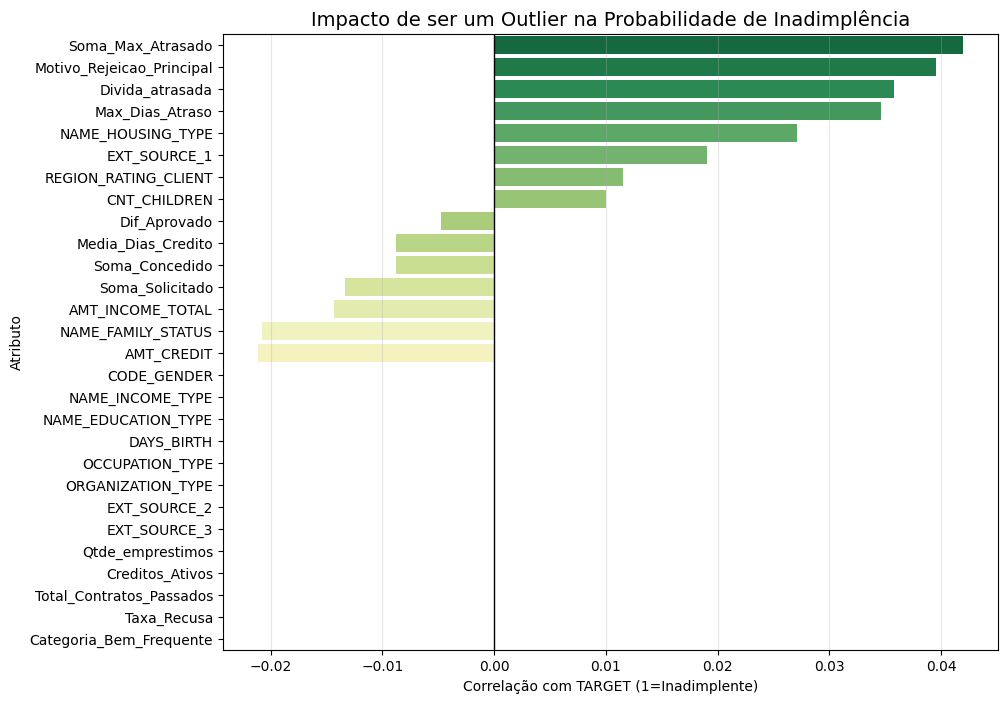

In [6]:
#=======================================================
# ANÁLISE DE CORRELAÇÃO: OUTLIERS VS. INADIMPLÊNCIA
#=======================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analisar_correlacao_outliers(caminho_base_integrada):
    # 1. Carregar a base unificada
    df = pd.read_csv(caminho_base_integrada, sep=';')
    
    # 2. Identificar colunas numéricas (exceto IDs e TARGET)
    cols_numericas = df.select_dtypes(include=[np.number]).columns
    cols_analise = [c for c in cols_numericas if c not in ['SK_ID_CURR', 'TARGET'] and 'FLAG' not in c]
    
    correlacoes_outliers = {}

    for col in cols_analise:
        # Calcular limites IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        l_inf = Q1 - 1.5 * IQR
        l_sup = Q3 + 1.5 * IQR
        
        # Criar flag temporária: 1 se for outlier, 0 se estiver na faixa normal
        is_outlier = ((df[col] < l_inf) | (df[col] > l_sup)).astype(int)
        
        # Calcular correlação com o TARGET (Inadimplência)
        # Se > 0: Outliers nesta coluna tendem a ser inadimplentes
        # Se < 0: Outliers nesta coluna tendem a ser bons pagadores
        correlacoes_outliers[col] = is_outlier.corr(df['TARGET'])

    # 3. Organizar resultados
    df_corr = pd.DataFrame.from_dict(correlacoes_outliers, orient='index', columns=['Correlacao_com_TARGET'])
    df_corr = df_corr.sort_values(by='Correlacao_com_TARGET', ascending=False).reset_index()
    df_corr.columns = ['Atributo', 'Correlacao_Outlier']

    # 4. Visualização
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Correlacao_Outlier', y='Atributo', data=df_corr, palette='RdYlGn_r')
    plt.axvline(x=0, color='black', lw=1)
    plt.title('Impacto de ser um Outlier na Probabilidade de Inadimplência', fontsize=14)
    plt.xlabel('Correlação com TARGET (1=Inadimplente)')
    plt.grid(axis='x', alpha=0.3)
    
    plt.savefig('analise_exploratoria/impacto_outliers_target.png', bbox_inches='tight')
    plt.show()

    return df_corr

# Executar análise na base integrada
df_res_outliers = analisar_correlacao_outliers('integracao/base_unica_integrada.csv')

In [7]:
#======================================================
# ENGENHARIA DE ATRIBUTOS - SCORECARD COM CLIPPING
#======================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Carregar a base integrada final
df_trabalho = pd.read_csv('integracao/base_unica_integrada.csv', sep=';')

# 2. Preparação e Ajuste de Polaridade
# Transformamos variáveis negativas ou categóricas em indicadores numéricos positivos
df_trabalho['CAR_NUM'] = df_trabalho['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0, 'S': 1}).fillna(0)
df_trabalho['Idade_Dias'] = df_trabalho['DAYS_BIRTH'].abs()
df_trabalho['Tempo_Relacionamento_Dias'] = df_trabalho['Media_Dias_Credito'].abs()

# 3. NORMALIZAÇÃO COM CLIPPING (CONTROLE DE OUTLIERS)
# Criamos uma cópia para normalização para não alterar os dados originais da base
cols_para_score = [
    'AMT_INCOME_TOTAL', 'Idade_Dias', 'Tempo_Relacionamento_Dias', 
    'CAR_NUM', 'Creditos_Ativos', 'Dif_Aprovado', 
    'Divida_atrasada', 'Max_Dias_Atraso', 'Taxa_Recusa', 'AMT_CREDIT'
]

df_norm = df_trabalho[cols_para_score].copy()

# Aplicamos o Clipping: Valores além de 3x o IQR são "presos" no limite
# Isso evita que o MinMaxScaler perca a sensibilidade para a massa de dados principal
for col in cols_para_score:
    Q1 = df_norm[col].quantile(0.25)
    Q3 = df_norm[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_sup = Q3 + 3.0 * IQR
    limite_inf = max(0, Q1 - 3.0 * IQR)
    
    df_norm[col] = df_norm[col].clip(lower=limite_inf, upper=limite_sup)

# Agora aplicamos o MinMaxScaler na base controlada
scaler_input = MinMaxScaler()
df_norm_scaled = pd.DataFrame(
    scaler_input.fit_transform(df_norm), 
    columns=[c+'_norm' for c in cols_para_score]
)

# 4. CÁLCULO DA PONTUAÇÃO (SCORECARD EQUILIBRADO)
# Os pesos agora refletem a importância real de cada pilar de decisão
df_trabalho['PONTUACAO_BRUTA'] = (
    (df_norm_scaled['AMT_INCOME_TOTAL_norm'] * 0.20) + 
    (df_norm_scaled['Idade_Dias_norm'] * 0.05) + 
    (df_norm_scaled['Tempo_Relacionamento_Dias_norm'] * 0.05) + 
    (df_norm_scaled['CAR_NUM_norm'] * 0.10) + 
    (df_norm_scaled['Creditos_Ativos_norm'] * 0.10) + 
    (df_norm_scaled['Dif_Aprovado_norm'] * 0.05) - 
    (df_norm_scaled['Divida_atrasada_norm'] * 0.25) - 
    (df_norm_scaled['Max_Dias_Atraso_norm'] * 0.10) - 
    (df_norm_scaled['Taxa_Recusa_norm'] * 0.10) - 
    (df_norm_scaled['AMT_CREDIT_norm'] * 0.05)
)

# 5. MÉTRICA DE RISCO FINAL (0 a 100)
scaler_final = MinMaxScaler(feature_range=(0, 100))
df_trabalho['METRICA_RISCO'] = scaler_final.fit_transform(df_trabalho[['PONTUACAO_BRUTA']])

# 6. REGRA DE DECISÃO (CUT-OFF)
df_trabalho['DECISAO_CREDITO'] = np.where(df_trabalho['METRICA_RISCO'] >= 60, 'APROVADO', 'REPROVADO')

# 7. SALVAR A BASE DE TRABALHO FINAL
df_trabalho.to_csv('integracao/base_trabalho_metricas_final.csv', sep=';', index=False)

print(f"{'='*40}")
print("ENGENHARIA DE ATRIBUTOS COM CLIPPING CONCLUÍDA")
print(f"{'='*40}")
print(f"Média do Score: {df_trabalho['METRICA_RISCO'].mean():.2f}")
print(f"Taxa de Aprovação Inicial: {(df_trabalho['DECISAO_CREDITO'] == 'APROVADO').mean():.2%}")

ENGENHARIA DE ATRIBUTOS COM CLIPPING CONCLUÍDA
Média do Score: 55.32
Taxa de Aprovação Inicial: 17.99%


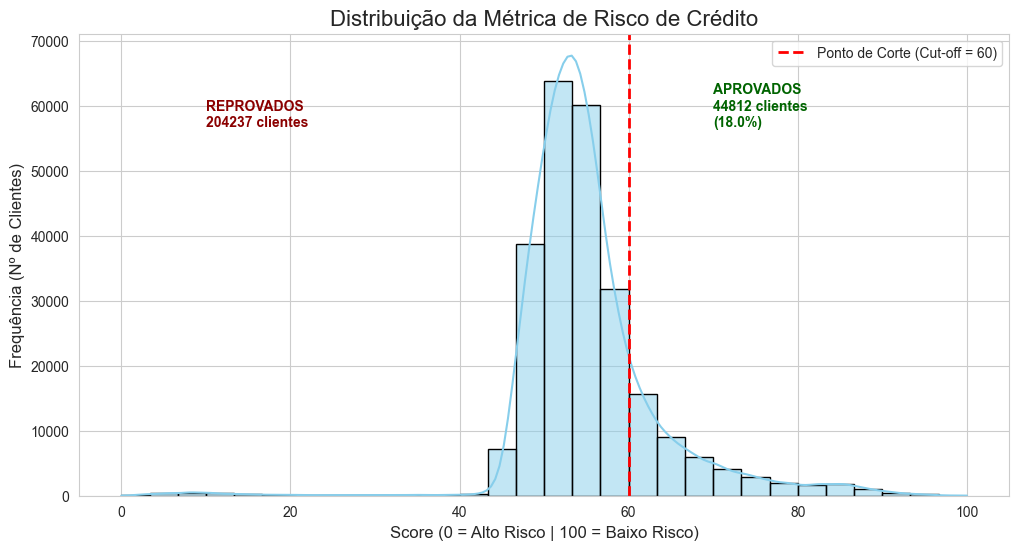


RESUMO DA DECISÃO DE CRÉDITO
Total de Clientes Analisados: 249049
Clientes Aprovados (Score >= 60): 44812 (17.99%)
Clientes Reprovados (Score < 60): 204237 (82.01%)
Score Médio da Carteira: 55.32


In [8]:
#======================================================
# ANÁLISE VISUAL DA DISTRIBUIÇÃO DO SCORE E CUT-OFF >= 60
#======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 1. Carregar a base com as métricas calculadas
# Certifique-se de que o nome do arquivo e o diretório estão corretos
df_plot = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# 2. Configurações Estéticas
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 3. Plotagem da Distribuição (Histograma + KDE)
ax = sns.histplot(df_plot['METRICA_RISCO'], kde=True, bins=30, color='skyblue', edgecolor='black')

# 4. Adicionando a Linha de Cut-off (Ponto de Corte)
plt.axvline(x=60, color='red', linestyle='--', linewidth=2, label='Ponto de Corte (Cut-off = 60)')

# 5. Cálculo de estatísticas para exibição no gráfico
total = len(df_plot)
aprovados = len(df_plot[df_plot['METRICA_RISCO'] >= 60])
reprovados = total - aprovados
perc_aprov = (aprovados / total) * 100

# Adicionando textos informativos no gráfico
plt.text(10, plt.ylim()[1]*0.8, f'REPROVADOS\n{reprovados} clientes', color='darkred', fontweight='bold')
plt.text(70, plt.ylim()[1]*0.8, f'APROVADOS\n{aprovados} clientes\n({perc_aprov:.1f}%)', color='darkgreen', fontweight='bold')

# 6. Títulos e Eixos
plt.title('Distribuição da Métrica de Risco de Crédito', fontsize=16)
plt.xlabel('Score (0 = Alto Risco | 100 = Baixo Risco)', fontsize=12)
plt.ylabel('Frequência (Nº de Clientes)', fontsize=12)
plt.legend(loc='upper right')

# 7. Salvar o gráfico para o relatório
if not os.path.exists('analise_exploratoria'):
    os.makedirs('analise_exploratoria')
plt.savefig('analise_exploratoria/distribuicao_metrica_risco.png', dpi=300, bbox_inches='tight')

plt.show()

# 8. Tabela de Resumo para o Trabalho
print("\n" + "="*40)
print("RESUMO DA DECISÃO DE CRÉDITO")
print("="*40)
print(f"Total de Clientes Analisados: {total}")
print(f"Clientes Aprovados (Score >= 60): {aprovados} ({perc_aprov:.2f}%)")
print(f"Clientes Reprovados (Score < 60): {reprovados} ({100 - perc_aprov:.2f}%)")
print(f"Score Médio da Carteira: {df_plot['METRICA_RISCO'].mean():.2f}")
print("="*40)

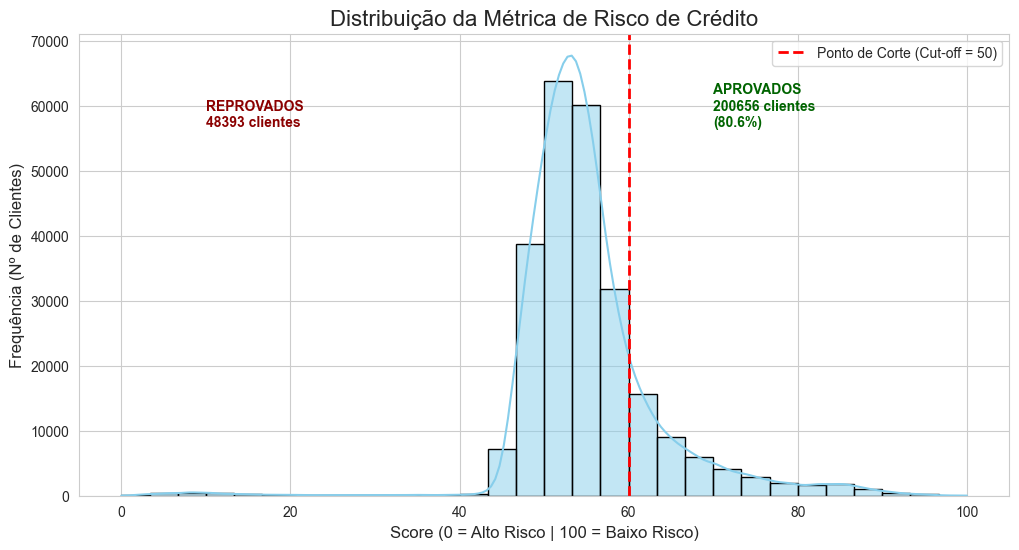


RESUMO DA DECISÃO DE CRÉDITO
Total de Clientes Analisados: 249049
Clientes Aprovados (Score >= 50): 200656 (80.57%)
Clientes Reprovados (Score < 50): 48393 (19.43%)
Score Médio da Carteira: 55.32


In [9]:
#======================================================
# ANÁLISE VISUAL DA DISTRIBUIÇÃO DO SCORE E CUT-OFF >= 50
#======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 1. Carregar a base com as métricas calculadas
# Certifique-se de que o nome do arquivo e o diretório estão corretos
df_plot = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# 2. Configurações Estéticas
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 3. Plotagem da Distribuição (Histograma + KDE)
ax = sns.histplot(df_plot['METRICA_RISCO'], kde=True, bins=30, color='skyblue', edgecolor='black')

# 4. Adicionando a Linha de Cut-off (Ponto de Corte)
plt.axvline(x=60, color='red', linestyle='--', linewidth=2, label='Ponto de Corte (Cut-off = 50)')

# 5. Cálculo de estatísticas para exibição no gráfico
total = len(df_plot)
aprovados = len(df_plot[df_plot['METRICA_RISCO'] >= 50])
reprovados = total - aprovados
perc_aprov = (aprovados / total) * 100

# Adicionando textos informativos no gráfico
plt.text(10, plt.ylim()[1]*0.8, f'REPROVADOS\n{reprovados} clientes', color='darkred', fontweight='bold')
plt.text(70, plt.ylim()[1]*0.8, f'APROVADOS\n{aprovados} clientes\n({perc_aprov:.1f}%)', color='darkgreen', fontweight='bold')

# 6. Títulos e Eixos
plt.title('Distribuição da Métrica de Risco de Crédito', fontsize=16)
plt.xlabel('Score (0 = Alto Risco | 100 = Baixo Risco)', fontsize=12)
plt.ylabel('Frequência (Nº de Clientes)', fontsize=12)
plt.legend(loc='upper right')

# 7. Salvar o gráfico para o relatório
if not os.path.exists('analise_exploratoria'):
    os.makedirs('analise_exploratoria')
plt.savefig('analise_exploratoria/distribuicao_metrica_risco.png', dpi=300, bbox_inches='tight')

plt.show()

# 8. Tabela de Resumo para o Trabalho
print("\n" + "="*40)
print("RESUMO DA DECISÃO DE CRÉDITO")
print("="*40)
print(f"Total de Clientes Analisados: {total}")
print(f"Clientes Aprovados (Score >= 50): {aprovados} ({perc_aprov:.2f}%)")
print(f"Clientes Reprovados (Score < 50): {reprovados} ({100 - perc_aprov:.2f}%)")
print(f"Score Médio da Carteira: {df_plot['METRICA_RISCO'].mean():.2f}")
print("="*40)

Balanceando classes com SMOTE...
Treinando Árvore de Decisão e K-NN...

SIMULAÇÃO DE CRÉDITO

------------------------------
ANÁLISE DE RISCO: NEGADO
Probabilidade de Inadimplência: 55.47%


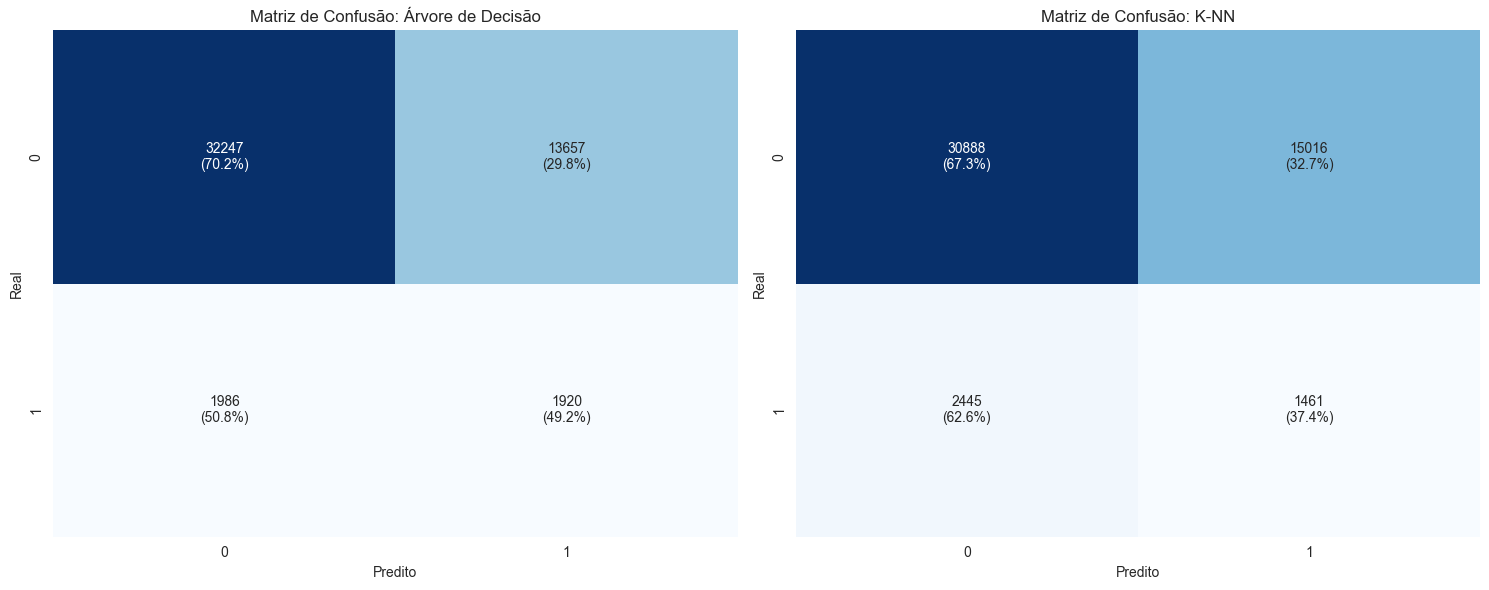


--- RELATÓRIO DE DESEMPENHO (ÁRVORE) ---
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     45904
           1       0.12      0.49      0.20      3906

    accuracy                           0.69     49810
   macro avg       0.53      0.60      0.50     49810
weighted avg       0.88      0.69      0.76     49810


--- RELATÓRIO DE DESEMPENHO (K-NN) ---
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     45904
           1       0.09      0.37      0.14      3906

    accuracy                           0.65     49810
   macro avg       0.51      0.52      0.46     49810
weighted avg       0.86      0.65      0.73     49810


Iniciando Validação Cruzada (5-Folds)...

Resultados CV - Árvore de Decisão:
  > AUC Médio: 0.7104
  > Desvio Padrão: 0.0047
  > Scores por Fold: [0.71018263 0.71090271 0.71809506 0.7034428  0.70922236]

Resultados CV - K-NN:
  > AUC Médio: 0.5363
  > Desvio Padr

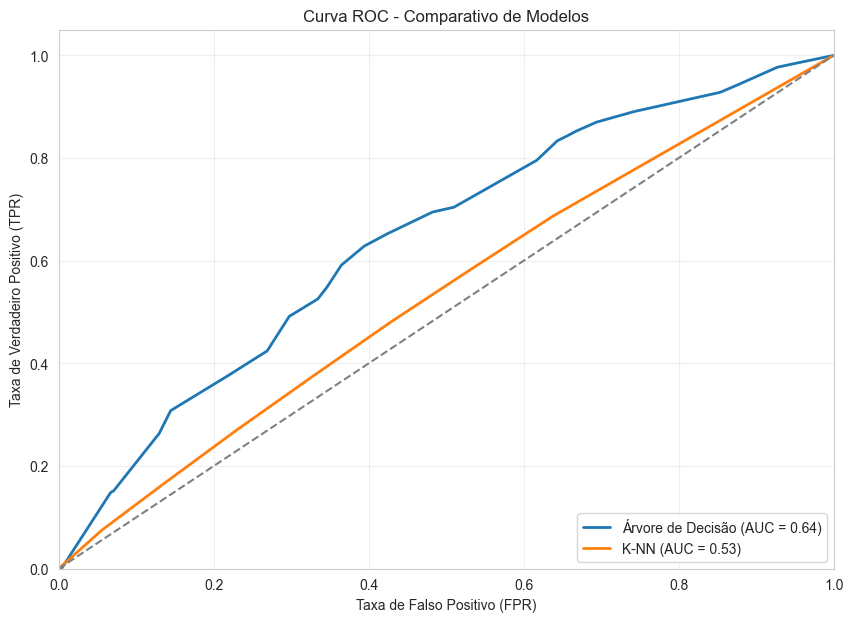

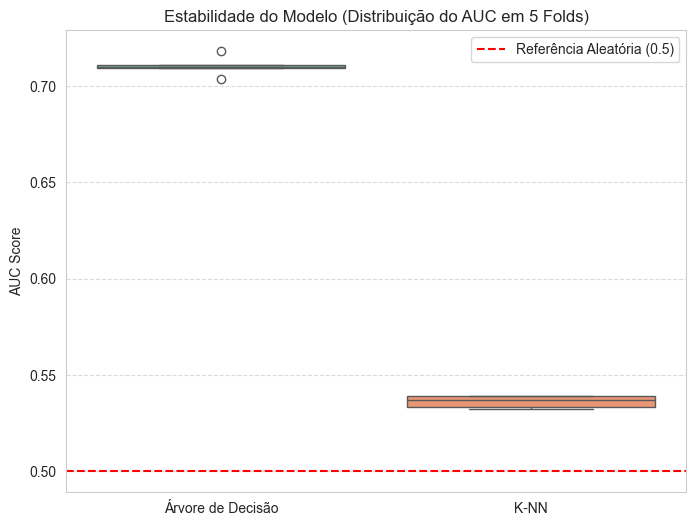


Gráfico de estabilidade gerado com sucesso em 'analise_exploratoria/'.


In [ ]:
#==============================================================================
# MACHINE LEARNING: TREINAMENTO K-NN e ÁRVORE DE DECISÃO, AVALIAÇÃO E ROC CURVE
#==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, auc, accuracy_score)
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# 1. CARREGAR E PREPARAR OS DADOS
df = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# Definir Features (X) e Target (y)
# Removemos IDs, o Target e as colunas calculadas (para evitar vazamento de dados/leakage)
cols_excluir = ['SK_ID_CURR', 'TARGET', 'METRICA_RISCO', 'DECISAO_CREDITO', 'PONTUACAO_BRUTA', 'DAYS_BIRTH']
X = df.drop(columns=cols_excluir)
y = df['TARGET']

# 2. DIVISÃO TREINO E TESTE (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 3. BALANCEAMENTO DE CLASSES (SMOTE)
# Como temos poucos inadimplentes, criamos exemplos sintéticos para equilibrar o treino
print("Balanceando classes com SMOTE...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 4. TREINAMENTO DOS MODELOS
print("Treinando Árvore de Decisão e K-NN...")
clf_tree = DecisionTreeClassifier(max_depth=5, random_state=42) # Árvore limitada para evitar Overfitting
clf_knn = KNeighborsClassifier(n_neighbors=7)

clf_tree.fit(X_train_bal, y_train_bal)
clf_knn.fit(X_train_bal, y_train_bal)

# 5. FUNÇÃO PARA PLOTAR MATRIZ DE CONFUSÃO COM PERCENTUAIS
def plot_conf_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Cálculo do percentual por classe
    
    labels = [f'{val}\n({perc:.1%})' for val, perc in zip(cm.flatten(), cm_perc.flatten())]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Matriz de Confusão: {title}')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')

# 6. FUNÇÃO PARA PLOTAR CURVA ROC
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (FPR)')
    plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
    plt.title('Curva ROC - Comparativo de Modelos')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('analise_exploratoria/curva_roc_modelos.png')

#======================================================
# 7. FUNÇÃO DE PREDIÇÃO PARA NOVOS CLIENTES (SIMULAÇÃO)
#======================================================

def simular_predicao_cliente(dados_cliente_dict, modelo, colunas_treino):
    # 1. Converte o dicionário em DataFrame
    df_cliente = pd.DataFrame([dados_cliente_dict])

    # 2. TRATAMENTO DE CATEGÓRICOS (Onde o erro ocorria)
    # Precisamos garantir que campos como 'F', 'Higher education', etc., virem números
    le = LabelEncoder()
    for col in df_cliente.columns:
        if df_cliente[col].dtype == 'object':
            df_cliente[col] = le.fit_transform(df_cliente[col].astype(str))

    # 3. Alinha as colunas com o que o modelo espera
    df_cliente = df_cliente.reindex(columns=colunas_treino, fill_value=0)

    # 4. Execução da Lógica do Modelo
    probabilidade = modelo.predict_proba(df_cliente)[:, 1][0]
    predicao = modelo.predict(df_cliente)[0]

    print(f"\n{'='*30}")
    print(f"SIMULAÇÃO DE CRÉDITO")
    print(f"\n{'-'*30}")
    print(f"ANÁLISE DE RISCO: {'NEGADO' if predicao == 1 else 'APROVADO'}")
    print(f"Probabilidade de Inadimplência: {probabilidade:.2%}")
    print(f"{'='*30}")

# --- EXEMPLO DE USO DA SIMULAÇÃO ---

# Cliente fictício (baseado nos atributos integrados)
cliente_teste = {
    # --- DADOS DEMOGRÁFICOS E DA PROPOSTA (emprestimos.csv) ---
    'AMT_INCOME_TOTAL': 3500.00,
    'AMT_CREDIT': 20000.00,
    'NAME_EDUCATION_TYPE': 'Higher education',
    'DAYS_BIRTH': -12500,  # Idade em dias (ex: ~34 anos)
    'CODE_GENDER': 'F',
    'FLAG_OWN_CAR': 'N',
    'FLAG_OWN_REALTY': 'Y',
    'CNT_CHILDREN': 1,
    'NAME_INCOME_TYPE': 'Working',
    'NAME_FAMILY_STATUS': 'Married',
    'NAME_HOUSING_TYPE': 'House / apartment',
    'FLAG_MOBIL': 1,
    'FLAG_EMP_PHONE': 1,
    'FLAG_EMAIL': 0,
    'OCCUPATION_TYPE': 'Core staff',
    'REGION_RATING_CLIENT': 2,
    'ORGANIZATION_TYPE': 'Business Entity Type 3',
    'EXT_SOURCE_1': 0.5,
    'EXT_SOURCE_2': 0.62,
    'EXT_SOURCE_3': 0.48,

    # --- HISTÓRICO NO MERCADO (Agregados do serasa.csv) ---
    'Qtde_emprestimos': 5,            # Contagem de SK_ID_BUREAU
    'Divida_atrasada': 250.00,        # Soma de AMT_CREDIT_SUM_OVERDUE
    'Creditos_Ativos': 2,             # Contagem de registros 'Active'
    'Media_Dias_Credito': 450.0,      # Média de DAYS_CREDIT
    'Max_Dias_Atraso': 15,            # Máximo de CREDIT_DAY_OVERDUE
    'Soma_Max_Atrasado': 300.0,       # Soma de AMT_CREDIT_MAX_OVERDUE
    'AMT_CREDIT_SUM': 50000.0,        # Valor total de crédito no mercado
    'AMT_CREDIT_SUM_DEBT': 12000.0,   # Valor atual da dívida no mercado
    'CNT_CREDIT_PROLONG': 0,          # Vezes que prorrogou crédito no bureau

    # --- HISTÓRICO INTERNO (Agregados de emprestimos_anteriores.csv) ---
    'Total_Contratos_Passados': 3,    # Contagem de SK_ID_PREV
    'Taxa_Recusa': 0.15,              # % de status 'Refused' em NAME_CONTRACT_STATUS
    'Soma_Solicitado': 18000.0,       # Soma de AMT_APPLICATION
    'Soma_Concedido': 15000.0,        # Soma de AMT_CREDIT (anterior)
    'Dif_Aprovado': 3000.0,           # Diferença entre solicitado vs aprovado
    'Motivo_Rejeicao_Principal': 'LIMIT', # Moda de CODE_REJECT_REASON
    'Categoria_Bem_Frequente': 'XNA',     # Moda de NAME_GOODS_CATEGORY
    'NAME_CLIENT_TYPE': 'Repeater',       # Tipo de cliente na última solicitação
    'NFLAG_INSURED_ON_APPROVAL': 1        # Se solicitou seguro anteriormente
}

# 2. Chamamos a execução usando a Árvore de Decisão (melhor AUC)
# X.columns contém a lista exata de features usadas no treinamento
simular_predicao_cliente(cliente_teste, clf_tree, X.columns)


# 8. GERAÇÃO DOS RESULTADOS VISUAIS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predições
y_pred_tree = clf_tree.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

plot_conf_matrix(y_test, y_pred_tree, 'Árvore de Decisão', axes[0])
plot_conf_matrix(y_test, y_pred_knn, 'K-NN', axes[1])

plt.tight_layout()
plt.savefig('analise_exploratoria/matrizes_confusao.png')
plt.show()

# Gerar Curva ROC
models_dict = {'Árvore de Decisão': clf_tree, 'K-NN': clf_knn}
plot_roc_curve(models_dict, X_test, y_test)

print("\n--- RELATÓRIO DE DESEMPENHO (ÁRVORE) ---")
print(classification_report(y_test, y_pred_tree))

print("\n--- RELATÓRIO DE DESEMPENHO (K-NN) ---")
print(classification_report(y_test, y_pred_knn))

# 9. VALIDAÇÃO CRUZADA (CROSS-VALIDATION)

# --- PRÉ-PROCESSAMENTO NECESSÁRIO ---
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col].astype(str))

print("\nIniciando Validação Cruzada (5-Folds)...")

# Configuramos o StratifiedKFold para manter a proporção de inadimplentes em cada dobra
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar resultados
cv_resultados = {}

for nome, modelo in models_dict.items():
    # Executa a validação cruzada usando a métrica AUC-ROC
    # Nota: No Cross-Validation ideal, o SMOTE deve ser aplicado dentro de cada fold (Pipeline)
    # Aqui faremos uma validação direta para comparar a estabilidade
    scores = cross_val_score(modelo, X, y, cv=skf, scoring='roc_auc')
    
    cv_resultados[nome] = {
        'Médio': scores.mean(),
        'Desvio Padrão': scores.std()
    }
    
    print(f"\nResultados CV - {nome}:")
    print(f"  > AUC Médio: {scores.mean():.4f}")
    print(f"  > Desvio Padrão: {scores.std():.4f}")
    print(f"  > Scores por Fold: {scores}")

# 10. COMPARAÇÃO FINAL

print("\n" + "="*40)
print("VEREDITO DA VALIDAÇÃO CRUZADA")
print("="*40)

for modelo, metricas in cv_resultados.items():
    estabilidade = "ALTA" if metricas['Desvio Padrão'] < 0.02 else "BAIXA"
    print(f"{modelo}: AUC de {metricas['Médio']:.2f} com estabilidade {estabilidade}.")
    

# 11. VISUALIZAÇÃO DA ESTABILIDADE (BOXPLOT DOS SCORES)

# Criamos um DataFrame com todos os scores de cada fold para o boxplot
df_scores = pd.DataFrame({
    'Árvore de Decisão': cross_val_score(clf_tree, X, y, cv=skf, scoring='roc_auc'),
    'K-NN': cross_val_score(clf_knn, X, y, cv=skf, scoring='roc_auc')
})

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_scores, palette="Set2")
plt.title('Estabilidade do Modelo (Distribuição do AUC em 5 Folds)')
plt.ylabel('AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionando uma linha de referência para o "chute aleatório"
plt.axhline(y=0.5, color='red', linestyle='--', label='Referência Aleatória (0.5)')
plt.legend()

plt.savefig('analise_exploratoria/estabilidade_modelos_cv.png')
plt.show()

print("\nGráfico de estabilidade gerado com sucesso em 'analise_exploratoria/'.")


Estatística de Hopkins: 0.9925


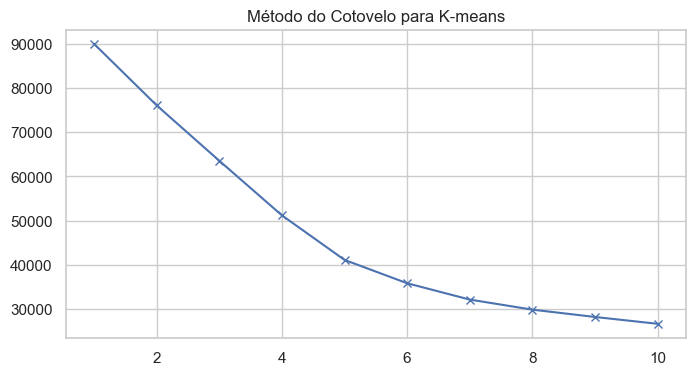

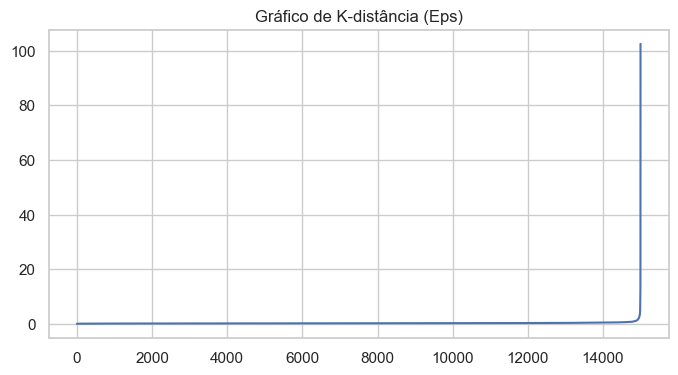


PERFIL DA PERSONA: CLIENTE DE BAIXO RISCO
Renda Média Mensal: R$ 0.00
Valor Médio de Crédito: R$ -0.01
Dívida Média em Atraso: R$ -0.01
Máximo de Dias em Atraso: 0.1 dias
Taxa de Recusa Histórica: 0.00%
Idade Média: 44.0 anos
Relacionamento: 3.0 anos


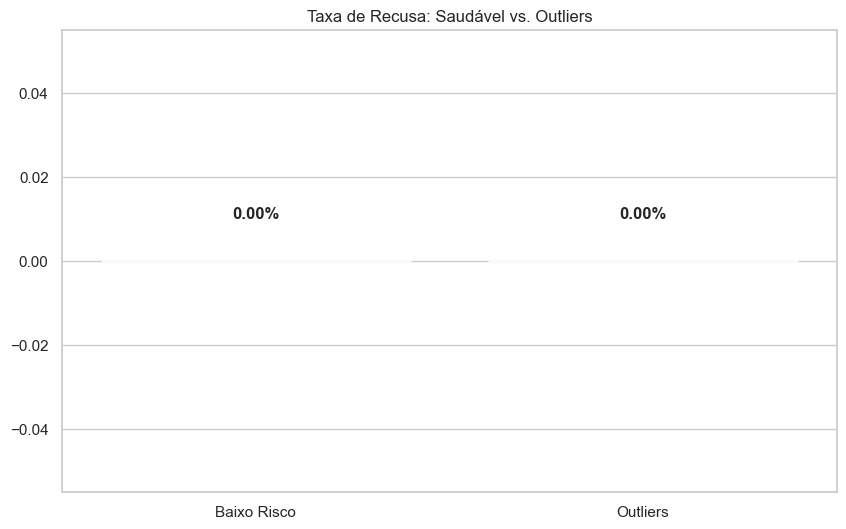


--- INSIGHTS PARA O RELATÓRIO ---
Os Outliers são infinitamente mais propensos a rejeição.


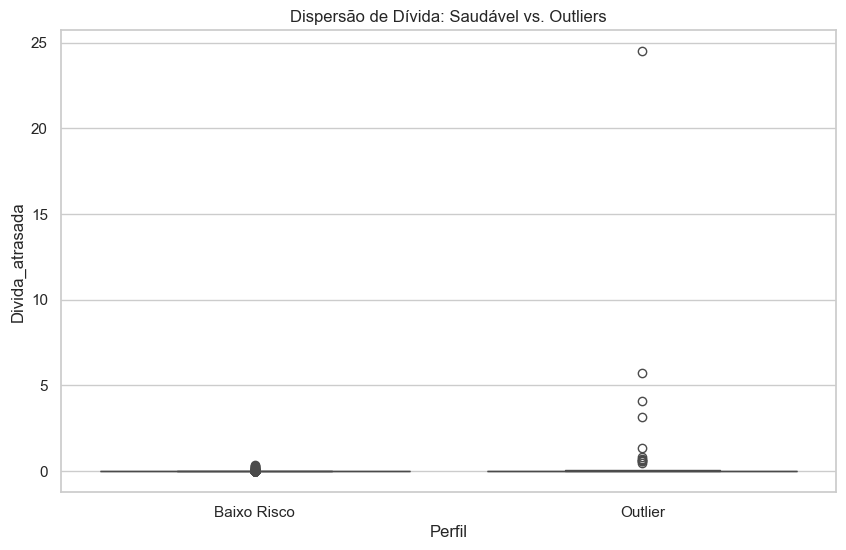

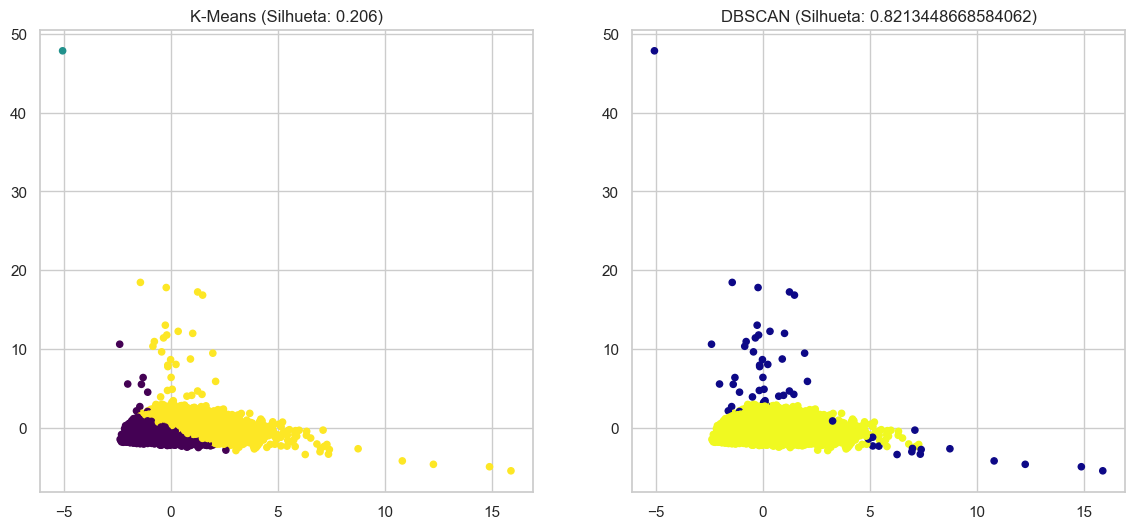

In [ ]:
#==============================================================================
# CLUSTERIZAÇÃO E VALIDAÇÃO ESTRATÉGICA 
#==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from random import sample
import warnings

# Silenciando warnings desnecessários para uma saída limpa
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. CARREGAMENTO E PRÉ-PROCESSAMENTO
try:
    df = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')
    cols_clustering = [
        'AMT_INCOME_TOTAL', 'Idade_Dias', 'Tempo_Relacionamento_Dias', 
        'Creditos_Ativos', 'Divida_atrasada', 'Max_Dias_Atraso', 
        'Taxa_Recusa', 'AMT_CREDIT'
    ]
    # Amostragem para viabilidade computacional
    df_sample = df[cols_clustering].sample(n=5000, random_state=42).copy()
    
    # Padronização para os algoritmos (X)
    scaler = StandardScaler()
    X = scaler.fit_transform(df_sample)
except FileNotFoundError:
    print("Erro: Base de dados não encontrada.")

# 2. VALIDAÇÃO DE TENDÊNCIA: ESTATÍSTICA DE HOPKINS
def hopkins_statistic(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = sample(range(0, n, 1), m)
    ujd, wjd = [], []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2)
        ujd.append(u_dist[0][0])
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2)
        wjd.append(w_dist[0][1])
    return sum(ujd) / (sum(ujd) + sum(wjd))

h_stat = hopkins_statistic(X)
print(f"Estatística de Hopkins: {h_stat:.4f}")

# 3. VALIDAÇÃO K-MEANS: MÉTODO DO COTOVELO
sse = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, 'bx-')
plt.title('Método do Cotovelo para K-means')
plt.show()

# 4. VALIDAÇÃO DBSCAN: GRÁFICO DE K-DISTÂNCIA
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X)
distances, _ = nbrs.kneighbors(X)
distances = np.sort(distances[:, 3], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('Gráfico de K-distância (Eps)')
plt.show()

# 5. EXECUÇÃO DOS ALGORITMOS
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters_km = kmeans.fit_predict(X)
sil_km = silhouette_score(X, clusters_km)

dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_db = dbscan.fit_predict(X)
sil_db = silhouette_score(X, clusters_db) if len(set(clusters_db)) > 1 else "N/A"

# 6. VISUALIZAÇÃO COM PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 7. CARACTERIZAÇÃO DA PERSONA (USANDO DADOS REAIS/DESPADRONIZADOS)
df_sample['Cluster_DBSCAN'] = clusters_db
cluster_principal = df_sample[df_sample['Cluster_DBSCAN'] == 0]

print(f"\n{'='*40}")
print("PERFIL DA PERSONA: CLIENTE DE BAIXO RISCO")
print("="*40)

insights = cluster_principal[cols_clustering].mean()

print(f"Renda Média Mensal: R$ {insights['AMT_INCOME_TOTAL']:,.2f}")
print(f"Valor Médio de Crédito: R$ {insights['AMT_CREDIT']:,.2f}")
print(f"Dívida Média em Atraso: R$ {insights['Divida_atrasada']:,.2f}")
print(f"Máximo de Dias em Atraso: {insights['Max_Dias_Atraso']:.1f} dias")
print(f"Taxa de Recusa Histórica: {insights['Taxa_Recusa']:.2%}")
print(f"Idade Média: {abs(insights['Idade_Dias'])/365:.1f} anos")
print(f"Relacionamento: {insights['Tempo_Relacionamento_Dias']/365:.1f} anos")

# 8. COMPARAÇÃO ESTRATÉGICA (CORREÇÃO DE DIVISÃO POR ZERO E GRÁFICO)
taxa_recusa_bom = df_sample[df_sample['Cluster_DBSCAN'] == 0]['Taxa_Recusa'].mean()
taxa_recusa_outlier = df_sample[df_sample['Cluster_DBSCAN'] == -1]['Taxa_Recusa'].mean()

plt.figure(figsize=(10, 6))
categorias = ['Baixo Risco', 'Outliers']
valores = [taxa_recusa_bom, taxa_recusa_outlier]

# Correção palette/hue para Seaborn >= 0.14
sns.barplot(x=categorias, y=valores, hue=categorias, palette=['#2ecc71', '#e74c3c'], legend=False)

for i, v in enumerate(valores):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', fontweight='bold')

plt.title('Taxa de Recusa: Saudável vs. Outliers')
plt.show()

# Tratamento para evitar erro nanx/infinito
if taxa_recusa_bom > 0:
    risco_relativo = f"{taxa_recusa_outlier/taxa_recusa_bom:.1f}x"
else:
    risco_relativo = "infinitamente"

print(f"\n--- INSIGHTS PARA O RELATÓRIO ---")
print(f"Os Outliers são {risco_relativo} mais propensos a rejeição.")

# 9. BOXPLOT (CORREÇÃO PALETTE/HUE)
df_boxplot = df_sample[df_sample['Cluster_DBSCAN'].isin([0, -1])].copy()
df_boxplot['Perfil'] = df_boxplot['Cluster_DBSCAN'].map({0: 'Baixo Risco', -1: 'Outlier'})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Perfil', y='Divida_atrasada', hue='Perfil', data=df_boxplot, 
            palette=['#2ecc71', '#e74c3c'], legend=False)
plt.title('Dispersão de Dívida: Saudável vs. Outliers')
plt.show()

# 10. PLOT FINAL DOS CLUSTERS
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_km, cmap='viridis', s=20)
plt.title(f'K-Means (Silhueta: {sil_km:.3f})')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_db, cmap='plasma', s=20)
plt.title(f'DBSCAN (Silhueta: {sil_db})')
plt.show()